In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import cv2


# for reading and displaying images
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
from PIL import Image
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [2]:
# Load in the data
# loading dataset
train = pd.read_csv('C:/Users/djcoo/NeuralNet_Project/Images/data_train.csv')
test = pd.read_csv('C:/Users/djcoo/NeuralNet_Project/Images/data_test.csv')

print(train)
print('\n')
print(test)

     Unnamed: 0                    path  class_id  minifigure_name_x  \
0           295     marvel/0001/002.jpg         1         SPIDER-MAN   
1           300     marvel/0001/003.jpg         1         SPIDER-MAN   
2           299     marvel/0001/009.jpg         1         SPIDER-MAN   
3           298     marvel/0001/010.jpg         1         SPIDER-MAN   
4           297     marvel/0001/005.jpg         1         SPIDER-MAN   
..          ...                     ...       ...                ...   
335         182  star-wars/0015/007.jpg        36  EMPEROR PALPATINE   
336         180            test/071.jpg        36  EMPEROR PALPATINE   
337         179  star-wars/0015/005.jpg        36  EMPEROR PALPATINE   
338         184  star-wars/0015/006.jpg        36  EMPEROR PALPATINE   
339         181            test/073.jpg        36  EMPEROR PALPATINE   

                   tmp_name  minifigure_name_y  
0            1 - SPIDER-MAN         SPIDER-MAN  
1            1 - SPIDER-MAN         S

In [3]:
#Convert the csv into a torch dataset
class LEGODataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, img_size, transform=None):
        self.df = pd.read_csv(csv_file)[['path','class_id']]
        #Dropping unnecessary columns
        self.root_dir = root_dir
        #Added Image Size
        self.img_size = img_size
        self.transform = transform


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        path = 'C:/Users/djcoo/NeuralNet_Project/Images/' + row['path']
        img = io.imread(path)
        img = skimage.transform.resize(img, self.img_size, anti_aliasing=True)
        #Added y to dict to showcase output labels
        #We're doing class_id - 1 because we want the output to be from 0 to N
        y = torch.tensor(row['class_id']-1, dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
        
        sample = {'image': img, 'id_min_1': y}
        #Returns as dict
        return sample

# Normalize, rescale, and "tensorizing"   
norm_transform = tv.transforms.Compose([
                                tv.transforms.ToTensor(),
                                #VERSATILE MEAN/STD FROM IMAGENET
                                tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])
                                      ])    
    
#CHANGE ACCORDINGLY (ROOTDIR)
torch_lego_train = LEGODataSet(csv_file = 'C:/Users/djcoo/NeuralNet_Project/Images/data_train.csv', 
                               root_dir = 'C:/Users/djcoo/NeuralNet_Project/Images/',
                               img_size = (256,256),
                               transform = norm_transform
                              )
torch_lego_test = LEGODataSet(csv_file = 'C:/Users/djcoo/NeuralNet_Project/Images/data_test.csv', 
                              root_dir = 'C:/Users/djcoo/NeuralNet_Project/Images/',
                              img_size = (256,256),
                              transform = norm_transform
                             )

dataloader_train = torch.utils.data.DataLoader(torch_lego_train, batch_size = 4, shuffle = True)
dataloader_test = torch.utils.data.DataLoader(torch_lego_test, batch_size = 4, shuffle = True)

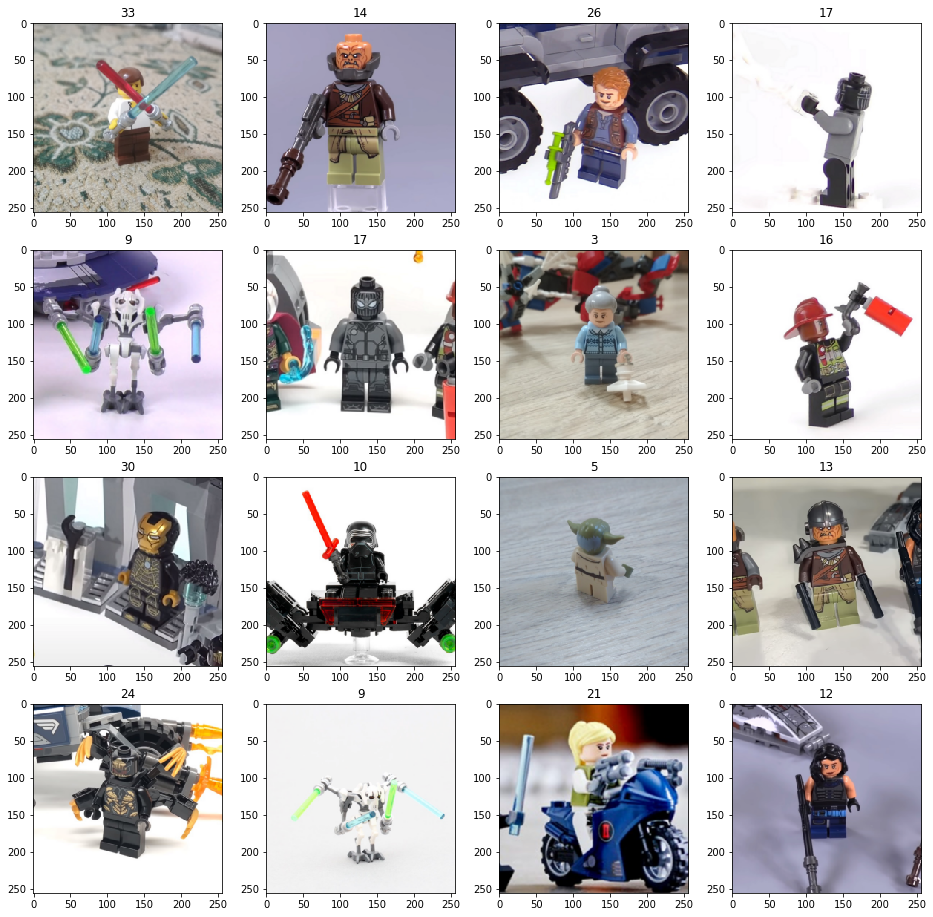

In [4]:
#For loop to normalize all train
fig = plt.figure(figsize=(16, 16))
#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_train):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.title(ids[j].numpy())
    if i==3:
        break

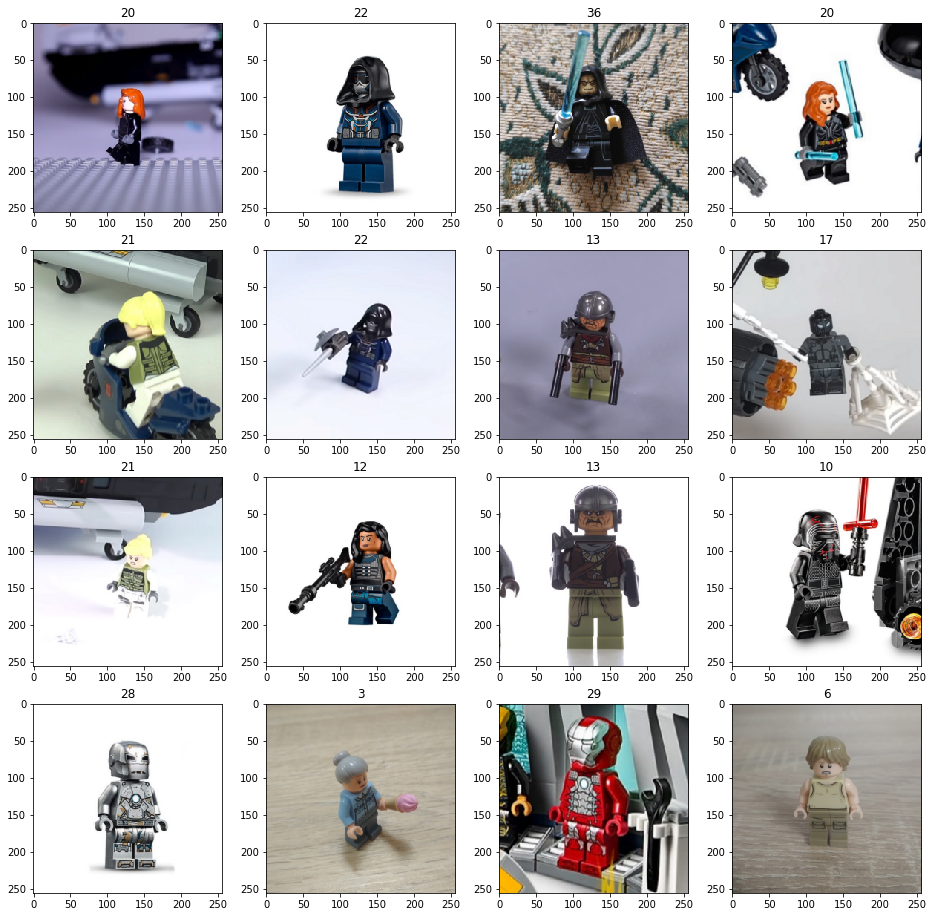

In [5]:
#For loop to normalize all test
fig = plt.figure(figsize=(16, 16))
#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_test):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.title(ids[j].numpy())
    if i==3:
        break

In [6]:
# Use GPUs, if not use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = tv.models.resnet18(pretrained=True)
net = net.cuda() if device else net
net

AssertionError: Torch not compiled with CUDA enabled